In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Comment here to add in for either mac or linux computer
# sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])  # For mac laptop
sys.path.extend(['/data/GitHub/NeuroPy'])  # for linux

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch, ProcessData, Neurons
from neuropy.io.spykingcircusio import SpykingCircusIO

#### Load in sessions

In [21]:
propofol_dir = "/data2/Opto/Jackie671/Jackie_propofol_2020-09-30/"
dex_dir = "/data2/Opto/Jackie671/Jackie_DEX/"
iso_dir = "/data2/Anesthesia/Han/2022_08_11_iso/"

plot_save_dir = Path("/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Grants/R01_Anesthesia_as_SD/plots")

#True = ripple detection for propofol and DEX on combined sessions (more false positive), False = detection on ANES portion only
use_combined_sessions = True  

sessions = {}

for sname, dir_use in zip(["propofol", "DEX", "iso"], [propofol_dir, dex_dir, iso_dir]):
    sess = ProcessData(dir_use)
    sess.neurons = Neurons.from_file(sess.filePrefix.with_suffix(".neurons.npy"), convert=True)
    sess.pbe_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".pbe.npy"))
    if (sname in ["propofol", "DEX"]) and use_combined_sessions:
        sess.ripple_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".ripple_from_full_session_aligned.npy"))
    else:
        sess.ripple_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".ripple.npy"))
    sess.prbgrp = core.ProbeGroup.from_file(sess.filePrefix.with_suffix(".probegroup.npy"), sort_shanks_by="x")
    if sname == "iso":
        sess.iso_times = Epoch(epochs=None, file=sess.filePrefix.with_suffix(".iso_timing.npy"))
        sess.iso_labels = ['3.0%iso', '2.5%iso', '2.1%iso', '1.75%iso', '1.35%iso', '1.0%iso', '0.8%iso', '0.6%iso', '0.4%iso']
    sessions[sname] = sess

### Plot SWR metrics

propofol Ripple rate = 0.004 Hz
propofol Total ripple duration / recording time = 0.0004
DEX Ripple rate = 0.006 Hz
DEX Total ripple duration / recording time = 0.0009
iso Ripple rate = 0.003 Hz
iso Total ripple duration / recording time = 0.0003


,rpl_rate,rpl_time_prop,session
0,0.003806,0.000392,propofol
1,0.006200,0.000932,DEX
2,0.002600,0.000328,iso


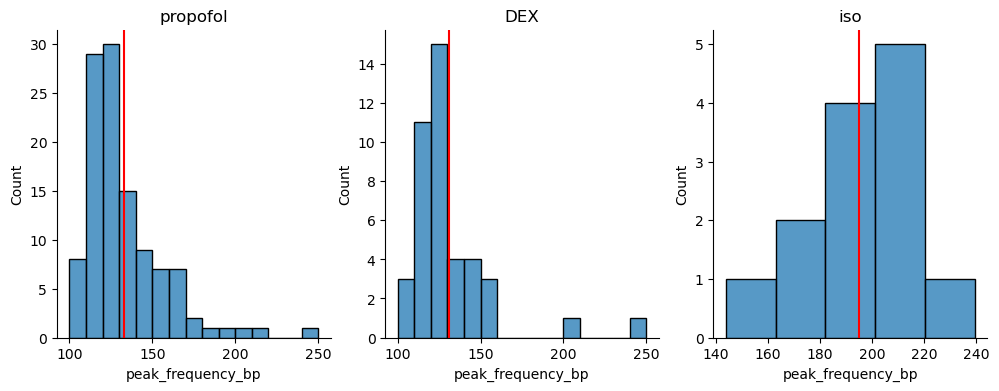

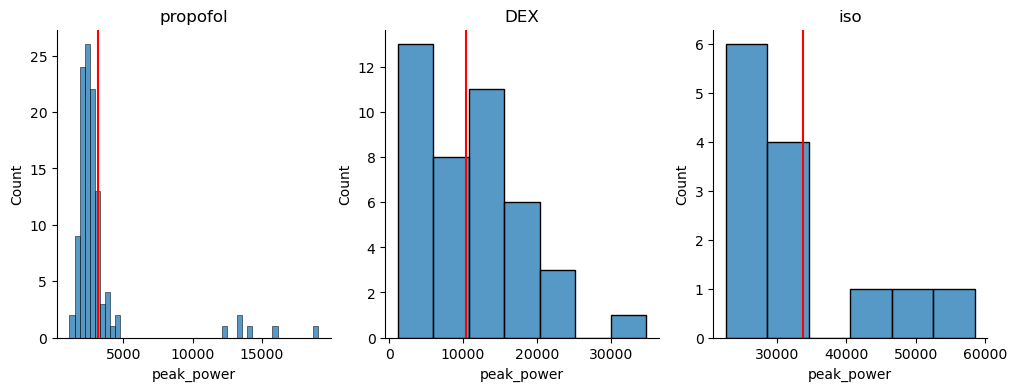

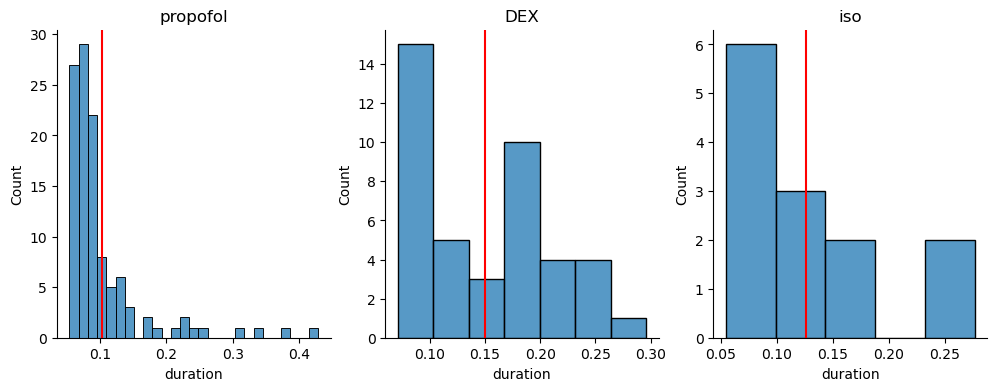

In [22]:
dur_thresh = 0
for metric in ["peak_frequency_bp", "peak_power", "duration"]:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for a, sname in zip(ax, ["propofol", "DEX", "iso"]):
    # for a, sname in zip(ax, ["iso"]):
        sess=sessions[sname]
        rip_df = sess.ripple_epochs.to_dataframe()
        rip_df = rip_df[rip_df.duration > dur_thresh]
        if sname == "iso":
            iso_epochs = sess.iso_times[sess.iso_labels]  # Grab only iso times for ripples
            rip_df = rip_df[(rip_df.start > iso_epochs.starts[0]) & (rip_df.stop < iso_epochs.stops[-1])]
        sns.histplot(data=rip_df, x=metric, ax=a)
        a.axvline(rip_df[metric].mean(), color='r')
        a.set_title(sname)
        sns.despine(ax=a)

rpl_rate_df = []
for sname in ["propofol", "DEX", "iso"]:
    sess=sessions[sname]
    rip_df = sess.ripple_epochs.to_dataframe()
    rip_df = rip_df[rip_df.duration > dur_thresh]
    if sname == "iso":
        iso_epochs = sess.iso_times[sess.iso_labels]  # Grab only iso times for ripples
        rip_df = rip_df[(rip_df.start > iso_epochs.starts[0]) & (rip_df.stop < iso_epochs.stops[-1])]
    rpl_rate = rip_df.shape[0] / sess.eegfile.duration
    rpl_time_per_sec = rip_df["duration"].values.sum() / sess.eegfile.duration
    rpl_rate_df.append(pd.DataFrame({"rpl_rate": rpl_rate, "rpl_time_prop": rpl_time_per_sec, "session": sname}, index=[0]))
    print(f"{sname} Ripple rate = {rpl_rate:.3f} Hz")
    print(f"{sname} Total ripple duration / recording time = {rpl_time_per_sec:0.4f}")
rpl_rate_df = pd.concat(rpl_rate_df, axis=0, ignore_index=True)
rpl_rate_df

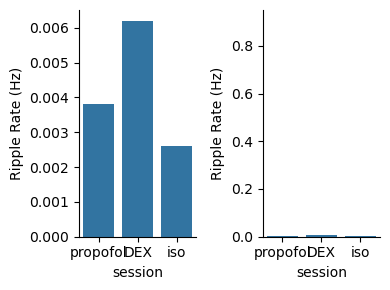

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(4, 3), layout="tight")
sns.barplot(data=rpl_rate_df, x="session", y="rpl_rate", ax=ax[0])
ax[0].set_ylabel("Ripple Rate (Hz)")
sns.barplot(data=rpl_rate_df, x="session", y="rpl_rate", ax=ax[1])
ax[1].set_ylim([0, 0.95])
ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax[1].set_ylabel("Ripple Rate (Hz)")
sns.despine(fig=fig)
fig.savefig(plot_save_dir / "Ripple_rates.pdf")

#### Plot Mean Wavelet for ripples

For DEX and propofol!

In [24]:
from neuropy.analyses.oscillations import Ripple
for sname in ["propofol", "DEX", "iso"]:
    sess = sessions[sname]
    
    rpl_chan_use = np.where(sess.ripple_epochs.metadata['channels'][0] == sess.prbgrp.channel_id)[0][0]

    if sname in ["propofol", "DEX"]:
        ripple_epochs_use = sess.ripple_epochs
        pbe_epochs_use = sess.pbe_epochs
    elif sname == "iso":
        iso_epochs = sess.iso_times[sess.iso_labels]
        ripple_epochs_use = sess.ripple_epochs.time_slice(t_start=iso_epochs.starts[0], t_stop=iso_epochs.stops[-1])
        pbe_epochs_use = sess.pbe_epochs.time_slice(t_start=iso_epochs.starts[0], t_stop=iso_epochs.stops[-1])
    
    wvlt_mean = Ripple.get_mean_wavelet(sess.eegfile, rpl_channel=rpl_chan_use, rpl_epochs=ripple_epochs_use)
    sess.swr_mean_wavelet = wvlt_mean

    pbe_epochs_use = pbe_epochs_use.add_column("mid", np.array((pbe_epochs_use.starts, pbe_epochs_use.stops)).mean(axis=0))
    wvlt_pbe_mean = Ripple.get_mean_wavelet(sess.eegfile, rpl_channel=rpl_chan_use, rpl_epochs=pbe_epochs_use, event_key="mid")
    sess.pbe_mean_wavelet = wvlt_pbe_mean


/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Issues with below to fix
1) propofol and DEX SWRs are detected using ANES times only and are likely identifying a lot of things that aren't ripples, though DEX looks ok
2) iso looks ok but there are only 13 ripples detected under iso!

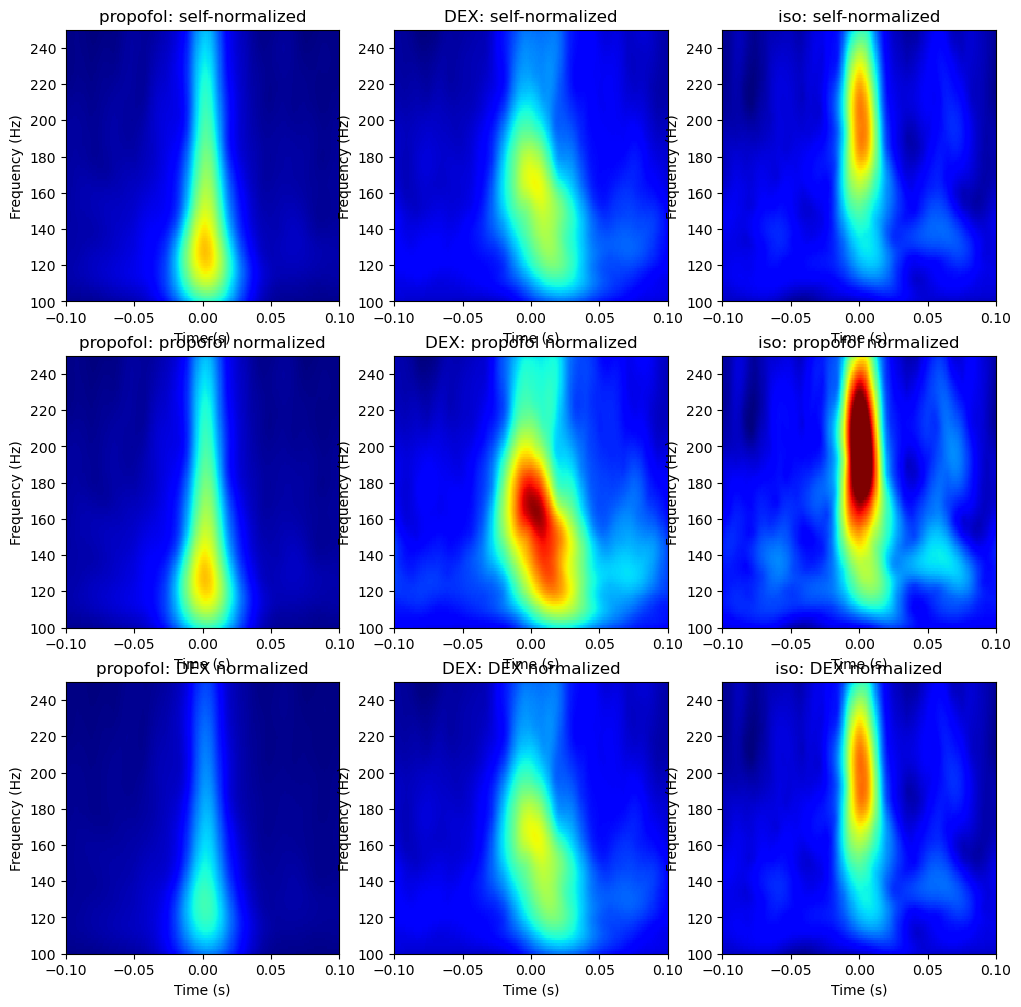

In [25]:
from neuropy.plotting.signals import plot_spectrogram
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for a, sname in zip(axs[0], ["propofol", "DEX", "iso"]):
    sess = sessions[sname]
    plot_spectrogram(sess.swr_mean_wavelet, time_lims=[-0.1, 0.1], freq_lims=(100, 250), widget=False, ax=a)
    a.set_title(f"{sname}: self-normalized")

sxx_std = np.std(sessions["propofol"].swr_mean_wavelet.traces)
for a, sname in zip(axs[1], ["propofol", "DEX", "iso"]):
    sess = sessions[sname]
    plot_spectrogram(sess.swr_mean_wavelet, time_lims=[-0.1, 0.1], freq_lims=(100, 250), widget=False, std_sxx=sxx_std, ax=a)
    a.set_title(f"{sname}: propofol normalized")

sxx_std = np.std(sessions["DEX"].swr_mean_wavelet.traces)
for a, sname in zip(axs[2], ["propofol", "DEX", "iso"]):
    sess = sessions[sname]
    plot_spectrogram(sess.swr_mean_wavelet, time_lims=[-0.1, 0.1], freq_lims=(100, 250), widget=False, std_sxx=sxx_std, ax=a)
    a.set_title(f"{sname}: DEX normalized")

fig.savefig(plot_save_dir / "DEX_v_propfol_SWR_wavelets.pdf")
    

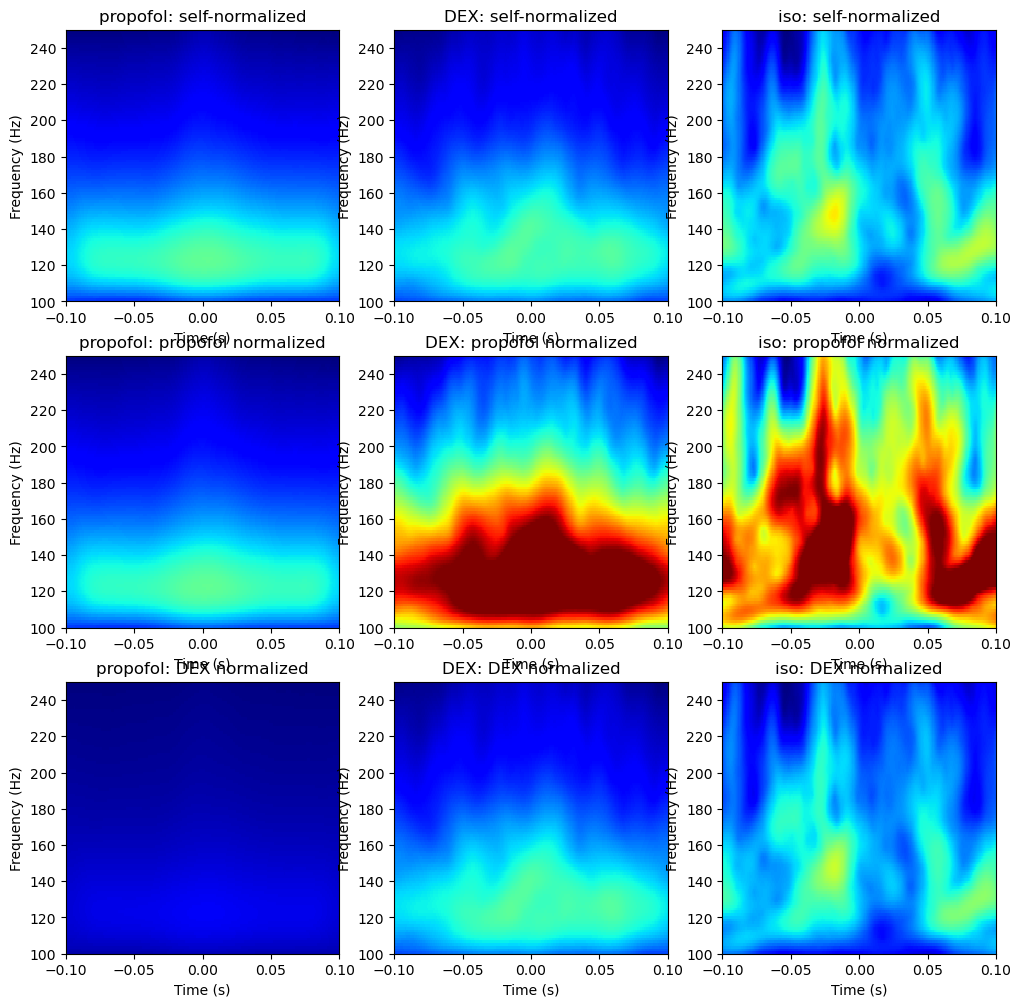

In [26]:
from neuropy.plotting.signals import plot_spectrogram
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for a, sname in zip(axs[0], ["propofol", "DEX", "iso"]):
    sess = sessions[sname]
    plot_spectrogram(sess.pbe_mean_wavelet, time_lims=[-0.1, 0.1], freq_lims=(100, 250), widget=False, ax=a)
    a.set_title(f"{sname}: self-normalized")

sxx_std = np.std(sessions["propofol"].pbe_mean_wavelet.traces)
for a, sname in zip(axs[1], ["propofol", "DEX", "iso"]):
    sess = sessions[sname]
    plot_spectrogram(sess.pbe_mean_wavelet, time_lims=[-0.1, 0.1], freq_lims=(100, 250), widget=False, std_sxx=sxx_std, ax=a)
    a.set_title(f"{sname}: propofol normalized")

sxx_std = np.std(sessions["DEX"].pbe_mean_wavelet.traces)
for a, sname in zip(axs[2], ["propofol", "DEX", "iso"]):
    sess = sessions[sname]
    plot_spectrogram(sess.pbe_mean_wavelet, time_lims=[-0.1, 0.1], freq_lims=(100, 250), widget=False, std_sxx=sxx_std, ax=a)
    a.set_title(f"{sname}: DEX normalized")

fig.savefig(plot_save_dir / "DEX_v_propfol_PBE_wavelets.pdf")

### NRK TODOs:
0) Cluster iso session
1) Plot PBE metrics for each session
2) Plot PSD across whole session for each type of ANES to highlight differences perhaps?
3) Yes to above, need to compare activity rate during wake ripples versus ANES ripples

#### Plot PBE metrics!
Take home from below: DEX has PBE activity that is generally aligned to SWRs and is longer in duration. Propofol is generally aligned but truncates very quickly after peak ripple time. Iso appears to have longer PBEs but that are not reliably aligned to the ripple peak AND there are only two ripples for iso levels of 1% or higher.

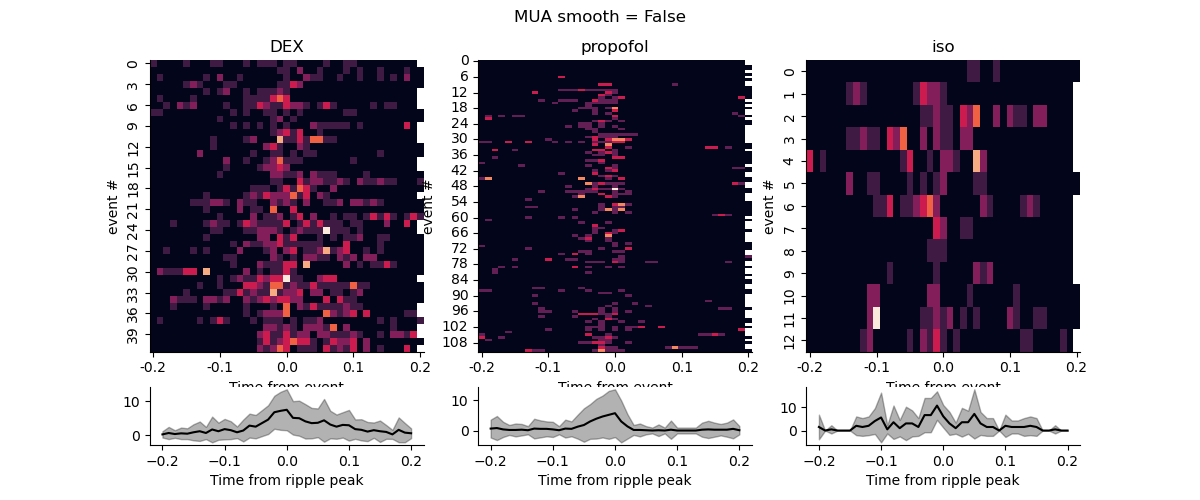

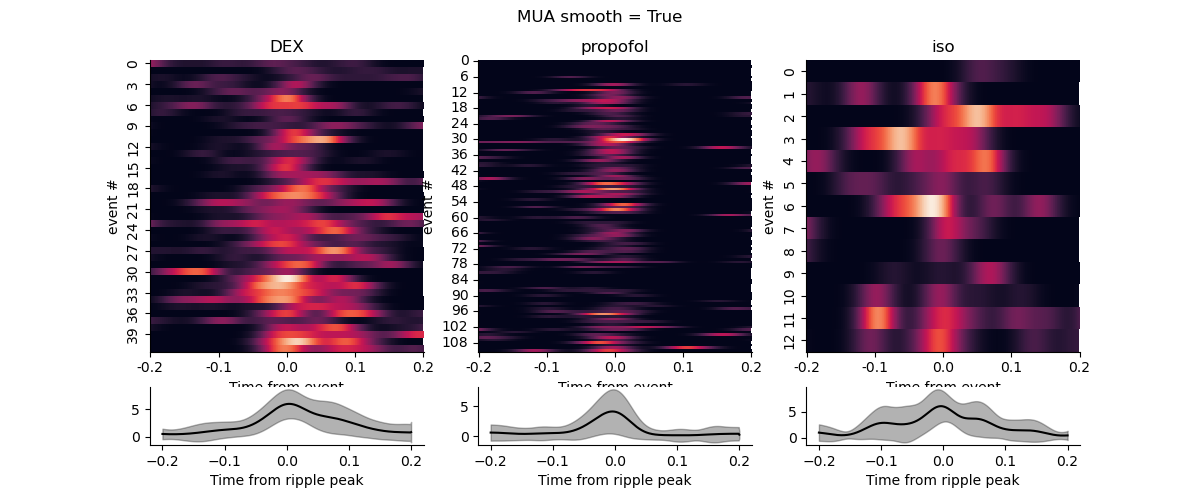

In [27]:
%matplotlib widget
norm_by_n_neurons = True
buffer_sec = (0.2, 0.2)
from neuropy.plotting.spikes import plot_mua, plot_raster, plot_binned_raster

for smooth_mua in [False, True]:
    fig, axall = plt.subplots(2, 3, height_ratios=[5, 1], figsize=(12, 5), sharex=False)
    fig.suptitle(f"MUA smooth = {smooth_mua}")
    for axs, sname in zip(axall.T, ["DEX", "propofol", "iso"]):
        sess = sessions[sname]
        neurons = sess.neurons.get_neuron_type([1, 2, 3])
        if not smooth_mua:
            sess.mua = neurons.get_mua(bin_size=0.01)
        elif smooth_mua:
            sess.mua = neurons.get_mua(bin_size=0.001).get_smoothed(sigma=0.02)
        # plot_mua(sess.mua)
    
        if sname in ["propofol", "DEX"]:
            ripple_epochs_use = sess.ripple_epochs
        elif sname == "iso":
            iso_epochs = sess.iso_times[sess.iso_labels]
            ripple_epochs_use = sess.ripple_epochs.time_slice(t_start=iso_epochs.starts[0], t_stop=iso_epochs.stops[-1])
        
        ax, fr_array, pe_times = plot_binned_raster(sess.mua, ripple_epochs_use.to_dataframe()["peak_time"].values, buffer_sec=buffer_sec, 
                                                    ax=axs[0], cbar=None)
        
        axs[0].set_title(sname)
    
        fr_mean, fr_std = np.nanmean(fr_array, axis=0), np.nanstd(fr_array, axis=0)
        fr_norm = neurons.n_neurons if norm_by_n_neurons else 1
        axs[1].plot(pe_times, fr_mean / fr_norm, 'k-')
        axs[1].fill_between(pe_times, (fr_mean - fr_std) / fr_norm, (fr_mean + fr_std) / fr_norm, color=[0, 0, 0, 0.3])
        axs[1].set_xlabel("Time from ripple peak")
    
    sns.despine(fig=fig)
fig.savefig(plot_save_dir / "Rough SWR MUA PSTH plots.pdf")

In [28]:
# Get probability each cell is active during a ripple
sess = sessions["propofol"]
neurons = sess.neurons.get_neuron_type([1, 2, 3])
binned_spiketrains = neurons.get_binned_spiketrains(bin_size=0.005)
rasters = []
for neuron_id in binned_spiketrains.neuron_ids:
    fr_array_use, pe_times = core.neurons.binned_pe_raster(binned_spiketrains, event_times=sess.ripple_epochs.to_dataframe()["peak_time"].values, 
                                                           neuron_id=neuron_id, buffer_sec=buffer_sec)
    rasters.append(fr_array_use)
    
# spikes_in_ripples, _ = neurons.get_spikes_in_epochs(sess.ripple_epochs)

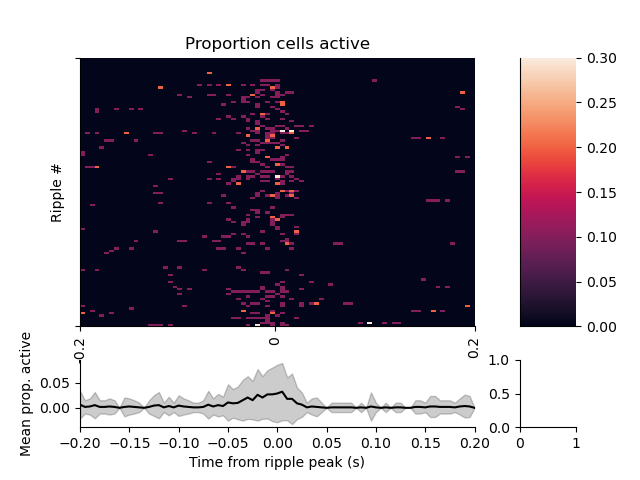

In [29]:
fig, axs = plt.subplots(2, 2, height_ratios=[4, 1], width_ratios=[7, 1])
prop_active_array = (np.stack(rasters, axis=2) > 0).mean(axis=2)

ax = axs[0][0]
axc = axs[0][1]
sns.heatmap(prop_active_array, ax=ax, cbar_ax=axc)
ax.set_title("Proportion cells active")
ax.set_xlabel("Time from ripple peak (s)")
ax.set_yticks([0, sess.ripple_epochs.n_epochs])
ax.set_ylabel("Ripple #")
ax.set_xticks([0, int(len(pe_times)/2), len(pe_times)])
ax.set_xticklabels([pe_times[0], 0, -pe_times[0]])

ax = axs[1][0]
prop_mean, prop_std = np.mean(prop_active_array, axis=0), np.std(prop_active_array, axis=0)
ax.plot(pe_times, prop_mean, 'k-')
ax.fill_between(pe_times, prop_mean - prop_std, prop_mean + prop_std, color=[0, 0, 0, 0.2])
ax.set_ylabel("Mean prop. active")
ax.set_xlabel("Time from ripple peak (s)")
ax.set_xlim([-buffer_sec[0], buffer_sec[1]])
sns.despine(fig=fig)

#### Plot example SWRs with PBE and w/o PBE

##### FOR DEX

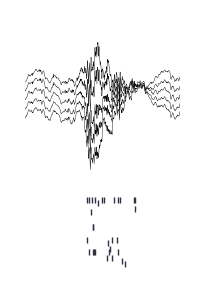

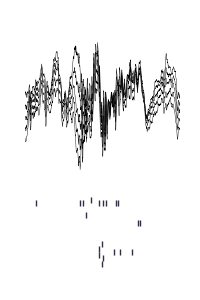

In [30]:
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster
sess = sessions["DEX"]
sess.ripple_epochs
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2, 3), height_ratios=[4, 2])

rip_use = sess.ripple_epochs.time_slice(t_start=105*60, t_stop=110*60)
sig_use = sess.eegfile.get_signal(channel_indx=sess.recinfo.channel_groups.reshape(-1).astype(int))
buffer = 0.25

# Plot ripple
ch_use = np.array([ch if ch in sess.prbgrp.get_connected_channels() else -1 for ch in sess.prbgrp.get_channels().squeeze()[24:32]])
ch_use = ch_use[ch_use != -1]
plot_signal_traces(sig_use.time_slice(t_start = rip_use.starts[0] - buffer, t_stop = rip_use.stops[0] + buffer, 
                                      channel_id=ch_use), lw=0.3, ax=ax[0])

# Plot spiking
neurons_use = sess.neurons.get_neuron_type([1, 2, 3]).time_slice(t_start = rip_use.starts[0] - buffer, t_stop = rip_use.stops[0] + buffer)
plot_raster(neurons_use, markersize=4, ax=ax[1])

sns.despine(fig=fig, left=True, bottom=True)
for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    a.set_xlabel("")
    a.set_ylabel("")

fig.savefig(plot_save_dir / "DEX_example_SWR_w_PBE.pdf")

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2, 3), height_ratios=[4, 2])
pbe_use = sess.pbe_epochs.time_slice(t_start=108*60, t_stop=109*60)

# Plot signal at PBE
plot_signal_traces(sig_use.time_slice(t_start = pbe_use.starts[1] - buffer, t_stop = pbe_use.stops[1] + buffer, 
                                      channel_id=ch_use), lw=0.3, ax=ax[0])

# Plot spiking
neurons_use = sess.neurons.get_neuron_type([1, 2, 3]).time_slice(t_start = pbe_use.starts[1] - buffer, t_stop = pbe_use.stops[1] + buffer)
plot_raster(neurons_use, markersize=4, ax=ax[1])

sns.despine(fig=fig, left=True, bottom=True)
for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    a.set_xlabel("")
    a.set_ylabel("")

fig.savefig(plot_save_dir / "DEX_example_PBE_wo_SWR.pdf")

#### FOR Propofol

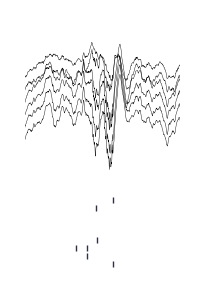

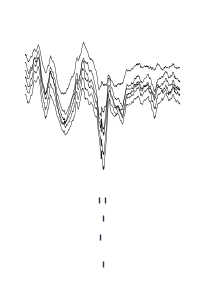

In [31]:
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster
sess = sessions["propofol"]
sess.ripple_epochs
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2, 3), height_ratios=[4, 2])

# rip_use = sess.ripple_epochs.time_slice(t_start=487*60 + 45, t_stop=487*60 + 48)
rip_use = sess.ripple_epochs.time_slice(t_start=466*60 + 9, t_stop=466*60 + 10)
sig_use = sess.eegfile.get_signal(channel_indx=sess.recinfo.channel_groups.reshape(-1).astype(int))
buffer = 0.25

# Plot ripple
ch_use = np.array([ch if ch in sess.prbgrp.get_connected_channels() else -1 for ch in [19, 31, 29, 17 ,18, 30]])
ch_use = ch_use[ch_use != -1]
plot_signal_traces(sig_use.time_slice(t_start = rip_use.starts[0] - buffer, t_stop = rip_use.stops[0] + buffer, 
                                      channel_id=ch_use), lw=0.3, ax=ax[0])

# Plot spiking
neurons_use = sess.neurons.get_neuron_type([1, 2, 3]).time_slice(t_start = rip_use.starts[0] - buffer, t_stop = rip_use.stops[0] + buffer)
plot_raster(neurons_use, markersize=4, ax=ax[1])

sns.despine(fig=fig, left=True, bottom=True)
for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    a.set_xlabel("")
    a.set_ylabel("")

fig.savefig(plot_save_dir / "propofol_example_SWR_w_PBE.pdf")

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2, 3), height_ratios=[4, 2])
pbe_use = sess.pbe_epochs.time_slice(t_start=487*60 + 45, t_stop=487*60 + 46)

# Plot signal at PBE
plot_signal_traces(sig_use.time_slice(t_start = pbe_use.starts[0] - buffer, t_stop = pbe_use.stops[0] + buffer, 
                                      channel_id=ch_use), lw=0.3, ax=ax[0])

# Plot spiking
neurons_use = sess.neurons.get_neuron_type([1, 2, 3]).time_slice(t_start = pbe_use.starts[0] - buffer, t_stop = pbe_use.stops[0] + buffer)
plot_raster(neurons_use, markersize=4, ax=ax[1])

sns.despine(fig=fig, left=True, bottom=True)
for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    a.set_xlabel("")
    a.set_ylabel("")

fig.savefig(plot_save_dir / "propofol_example_PBE_wo_SWR.pdf")

##### FOR ISO

In [39]:
# Note, clu.1 contains all neurons, clu.2 contains pyr neurons only
sess.recinfo.write_neurons(sess.neurons)
sess.recinfo.write_neurons(sess.neurons.get_neuron_type([1, 2, 3]), suffix_num=2)

PosixPath('/data2/Anesthesia/Han/2022_08_11_iso/Han_iso.clu.2')

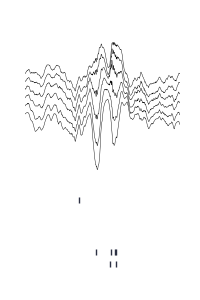

In [32]:
from neuropy.plotting.signals import plot_signal_traces
from neuropy.plotting.spikes import plot_raster
sess = sessions["iso"]
sess.ripple_epochs
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2, 3), height_ratios=[4, 2])

# rip_use = sess.ripple_epochs.time_slice(t_start=60*60 + 57, t_stop=60*60 + 58)
rip_use = sess.ripple_epochs.time_slice(t_start=62*60 + 37, t_stop=62*60 + 38)
sig_use = sess.eegfile.get_signal(channel_indx=sess.recinfo.channel_groups.reshape(-1).astype(int))
buffer = 0.25

# Plot ripple
ch_use = np.array([ch if ch in sess.prbgrp.get_connected_channels() else -1 for ch in np.arange(4, 10)])
ch_use = ch_use[ch_use != -1]
plot_signal_traces(sig_use.time_slice(t_start = rip_use.starts[0] - buffer, t_stop = rip_use.stops[0] + buffer, 
                                      channel_id=ch_use), lw=0.3, ax=ax[0])

# Plot spiking
neurons_use = sess.neurons.get_neuron_type([1, 2, 3]).time_slice(t_start = rip_use.starts[0] - buffer, t_stop = rip_use.stops[0] + buffer)
plot_raster(neurons_use, markersize=4, ax=ax[1])

sns.despine(fig=fig, left=True, bottom=True)
for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    a.set_xlabel("")
    a.set_ylabel("")

fig.savefig(plot_save_dir / "iso_example_SWR_w_PBE.pdf")

# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2, 3), height_ratios=[4, 2])
# pbe_use = sess.pbe_epochs.time_slice(t_start=487*60 + 45, t_stop=487*60 + 46)

# # Plot signal at PBE
# plot_signal_traces(sig_use.time_slice(t_start = pbe_use.starts[0] - buffer, t_stop = pbe_use.stops[0] + buffer, 
#                                       channel_id=ch_use), lw=0.3, ax=ax[0])

# # Plot spiking
# neurons_use = sess.neurons.get_neuron_type([1, 2, 3]).time_slice(t_start = pbe_use.starts[0] - buffer, t_stop = pbe_use.stops[0] + buffer)
# plot_raster(neurons_use, markersize=4, ax=ax[1])

# sns.despine(fig=fig, left=True, bottom=True)
# for a in ax:
#     a.set_yticks([])
#     a.set_xticks([])
#     a.set_xlabel("")
#     a.set_ylabel("")

# fig.savefig(plot_save_dir / "iso_example_PBE_wo_SWR.pdf")